# Modeling

This part of the project involves developing predictive models utilizing the scraped satellite imagery, to determine if an area is susceptible to wildfire in the state of Oregon. The initial step in this process was the generation of satellite photos in Notebook 1, followed by their visualization in Notebook 2.

**An overview of the notebook:**
1. [Data load and preprocessing](#dataload_id)
2. [Models](#models_id)
    1. [Baseline CNN model](#baselineCNN_id)
    2. [Expanded CNN model](#expandedCNN_id)
3. [Pre-trained models](#retrainedModels_id)
    1. [CNN with ResNet50](#resNet50_id) 
    2. [CNN with InceptionV3](#InceptionV3_id)
4. [Which is the best model?](#bestmodel_id)
5. [GradCAM](#gradCam_id)


### Packages

In [22]:
# Packages:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import folium
import numpy as np
import pandas as pd
import os
import random
import cv2

from matplotlib import pyplot as plt
from matplotlib import image as mpimgz
from keras.layers import Conv2D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.layers import Conv2D

# <a id='dataload_id'></a>Dataload and preprocessing

The first step is to preprocess two datasets containing satellite photos and split them into three datasets for training, validation, and testing. The code uses Keras' preprocessing functions to load the images and format them to size 224*224 before converting them into arrays of (224, 224, 3), with one array for each color channel in RGB. In this step, the code also creates a list containing a label of either 0 or 1, depending on the class of the image.

Once the images have been loaded and converted to arrays, the code adds each image array and its corresponding label to the appropriate list, based on whether it should be used for training, validation, or testing. Once all the image files have been processed, the code converts the lists of image arrays and labels to numpy arrays using the np.array() function. The code then concatenates the arrays for the fire and no-fire classes into separate training, validation, and testing datasets.

### Fire data

In [23]:
# Setting the path to the folder containing PNG images
folder_path_fire = 'NAIP - 2-7 måneder før brand, 250 meter x 250 meter - NY 2'

In [36]:
# Defining the fraction of the data to use for training, validation, and testing
train_fraction = 0.6 * len(os.listdir(folder_path_fire))
val_fraction = 0.2 * len(os.listdir(folder_path_fire))
test_fraction = 0.2 

# Initializing lists to store the data
train_images_fire = []
train_labels_fire = []
val_images_fire = []
val_labels_fire = []
test_images_fire = []
test_labels_fire = []

# Looping through all the PNG files in the folder
for filename in os.listdir(folder_path_fire):
    if filename.endswith('.png'):
        img = f'{folder_path_fire}/{filename}'
        image = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(image)
        
        # Add the image array and its corresponding label (which is always 1) to the appropriate list
        if len(train_images_fire) < train_fraction:
            train_images_fire.append(img_array)
            train_labels_fire.append(1)
        elif len(val_images_fire) < val_fraction:
            val_images_fire.append(img_array)
            val_labels_fire.append(1)
        else:
            test_images_fire.append(img_array)
            test_labels_fire.append(1)

# Converting the lists to numpy arrays
X_train_fire = np.array(train_images_fire)
y_train_fire = np.array(train_labels_fire)
X_val_fire = np.array(val_images_fire)
y_val_fire = np.array(val_labels_fire)
X_test_fire = np.array(test_images_fire)
y_test_fire = np.array(test_labels_fire)

### No fire data:

In [37]:
# Setting the path to the folder containing PNG images
folder_path_nofire = 'NAIP - 2-7 måneder før brand, 250 x 250 meter - Ikke brand'

In [38]:
# Initializing lists to store the data
train_images_nofire = []
train_labels_nofire = []
val_images_nofire = []
val_labels_nofire = []
test_images_nofire = []
test_labels_nofire = []

# Looping through all the PNG files in the folder
for filename in os.listdir(folder_path_nofire):
    if filename.endswith('.png'):
        img = f'{folder_path_nofire}/{filename}'
        image = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(image)
        
        # Add the image array and its corresponding label (which is always 0) to the appropriate list
        if len(train_images_nofire) < train_fraction:
            train_images_nofire.append(img_array)
            train_labels_nofire.append(0)
        elif len(val_images_nofire) < val_fraction:
            val_images_nofire.append(img_array)
            val_labels_nofire.append(0)
        else:
            test_images_nofire.append(img_array)
            test_labels_nofire.append(0)

# Converting the lists to numpy arrays
X_train_nofire = np.array(train_images_nofire)
y_train_nofire = np.array(train_labels_nofire)
X_val_nofire = np.array(val_images_nofire)
y_val_nofire = np.array(val_labels_nofire)
X_test_nofire = np.array(test_images_nofire)
y_test_nofire = np.array(test_labels_nofire)

## Combine the two datasets into one:

Next the generated arrays containing fire or no fire is concatenated to create one array for images and labels for each of the 3 splits.

In [39]:
# combing the two datasets
X_train = np.concatenate((X_train_fire, X_train_nofire))
y_train = np.concatenate((y_train_fire, y_train_nofire))

X_val = np.concatenate((X_val_fire, X_val_nofire))
y_val = np.concatenate((y_val_fire, y_val_nofire))

X_test = np.concatenate((X_test_fire, X_test_nofire))
y_test = np.concatenate((y_test_fire, y_test_nofire))

In [40]:
print('X_train: ', len(X_train))
print('y_train: ', len(y_train))
print('X_val: ', len(X_val))
print('y_val: ', len(y_val))
print('X_test: ', len(X_test))
print('y_test: ', len(y_test))

X_train:  2212
y_train:  2212
X_val:  738
y_val:  738
X_test:  738
y_test:  738


The number of elements in each split is as expected.

# <a id='models_id'></a>Models 

Since we have to do with a binary image classification problem, a CNN model is well suited. A Convolutional Neural Network (CNN) is a deep learning algorithm commonly used for image classification tasks. It is particularly suited for these tasks due to its ability to automatically learn features and patterns in the input data without requiring explicit feature engineering.

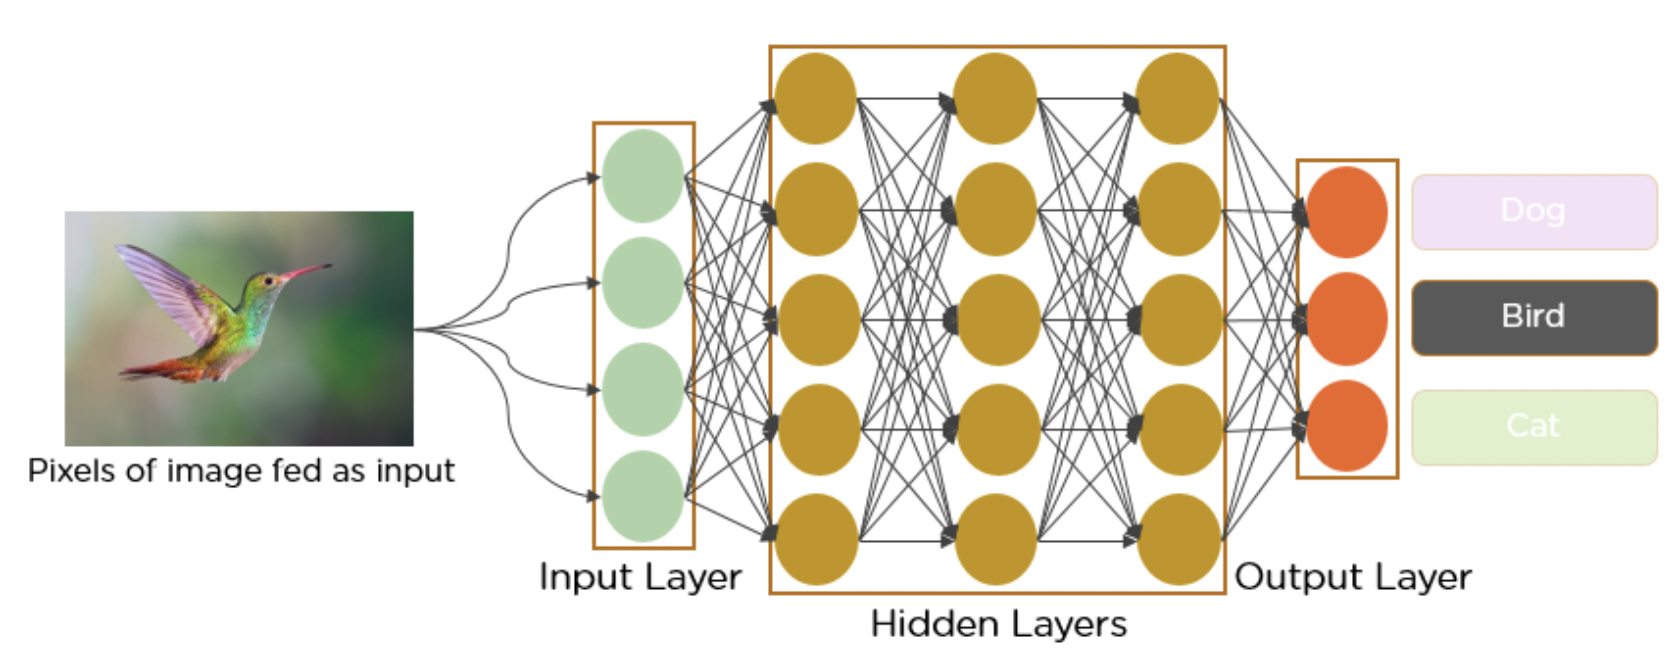

In a CNN, the input image is processed through a series of convolutional layers, which apply a set of filters to extract features from the image. These filters are learned through training, and their values are adjusted to minimize the error between the predicted and true labels of the training examples.

The output of the convolutional layers is then fed through a series of pooling layers, which downsample the feature maps and reduce the dimensionality of the data. This helps to reduce the computational complexity of the model and prevent overfitting.

The final layers of the CNN typically consist of fully connected layers, which are used to map the learned features to the output labels. In a binary image classification problem, the output layer would consist of a single node with a sigmoid activation function, which outputs a probability score between 0 and 1 indicating the likelihood of the image belonging to the positive class (e.g., containing fire).

The use of a CNN on a binary image classification problem is well-suited because it can effectively capture the visual patterns and features in the image data that are relevant to the classification task. Additionally, CNNs are highly parameterizable and can be tuned to achieve high accuracy on the task at hand.

## <a id='baselineCNN_id'></a>Baseline CNN model

The baseline CNN model architecture consists of several layers, including convolutional, max pooling, flatten, and dense layers. The model starts with a convolutional layer that uses 32 filters, each with a 3x3 kernel, and applies the ReLU activation function. This layer takes an input image of size 224x224x3, where 3 is the number of color channels in RGB. The output of this layer is passed through a max pooling layer with a 2x2 pool size, which helps reduce the spatial dimensions of the output.

The model then proceeds with another convolutional layer that uses 64 filters, each with a 3x3 kernel, and applies the ReLU activation function. This layer is again followed by a max pooling layer with a 2x2 pool size. The output of this layer is then flattened into a 1D tensor.

After flattening, the model has a dense layer with 215 neurons and uses the ReLU activation function. The final dense layer has 1 neuron, which is the output layer for binary classification, and uses the sigmoid activation function.

The model is then compiled with binary crossentropy loss and Adam optimizer, which is a commonly used loss function and optimizer for binary classification tasks. The accuracy metric is used to evaluate the performance of the model.

In [204]:
baseline_model = tf.keras.Sequential([
    # Convolutional layer 1 with 32 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # Max pooling layer 1 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Convolutional layer 3 with 128 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # Max pooling layer 3 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Flatten layer to transform 3D tensor to a 1D tensor
    tf.keras.layers.Flatten(),
    # Dense layer 1 with 215 neurons, activation function ReLU
    tf.keras.layers.Dense(215, activation='relu'),
    # Dense layer 2 with 1 neurons (output layer), activation function Sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compile the model with categorical crossentropy loss and Adam optimizer
baseline_model.compile(loss=tf.keras.losses.binary_crossentropy, 
                       optimizer="Adam", 
                       metrics=['accuracy'])

# Print model summary
baseline_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_396 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_397 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 186624)            0         
                                                                 
 dense_24 (Dense)            (None, 215)             

In [205]:
tf.random.set_seed(42)

baseline_history = baseline_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
70/70 [==============================] - 15s 196ms/step - loss: 284.6190 - accuracy: 0.5375 - val_loss: 0.8205 - val_accuracy: 0.5732
Epoch 2/10
70/70 [==============================] - 13s 180ms/step - loss: 0.6119 - accuracy: 0.7247 - val_loss: 0.8784 - val_accuracy: 0.6043
Epoch 3/10
70/70 [==============================] - 12s 176ms/step - loss: 0.3804 - accuracy: 0.8639 - val_loss: 0.9303 - val_accuracy: 0.6192
Epoch 4/10
70/70 [==============================] - 12s 178ms/step - loss: 0.2474 - accuracy: 0.9412 - val_loss: 1.2757 - val_accuracy: 0.6138
Epoch 5/10
70/70 [==============================] - 12s 177ms/step - loss: 0.1396 - accuracy: 0.9765 - val_loss: 1.4717 - val_accuracy: 0.6260
Epoch 6/10
70/70 [==============================] - 12s 179ms/step - loss: 0.1182 - accuracy: 0.9738 - val_loss: 1.1474 - val_accuracy: 0.6003
Epoch 7/10
70/70 [==============================] - 12s 177ms/step - loss: 0.0545 - accuracy: 0.9928 - val_loss: 1.6570 - val_accuracy: 0.60

In [208]:
baseline_model.save('baseline_model.h5')

The performance of this baseline model can then be evaluated.

In [209]:
loss, accuracy = baseline_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', accuracy)

Test accuracy: 0.6097561120986938


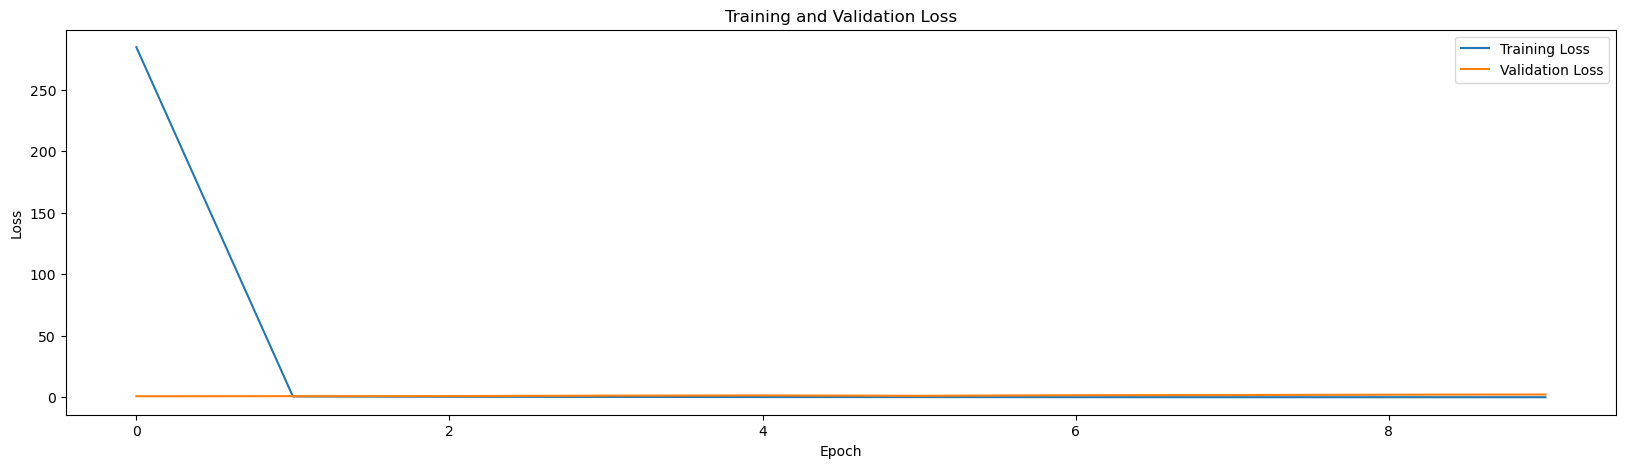

In [210]:
# Plotting training and validation loss
plt.figure(figsize=(20,5))
plt.plot(baseline_history.history['loss'], label='Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

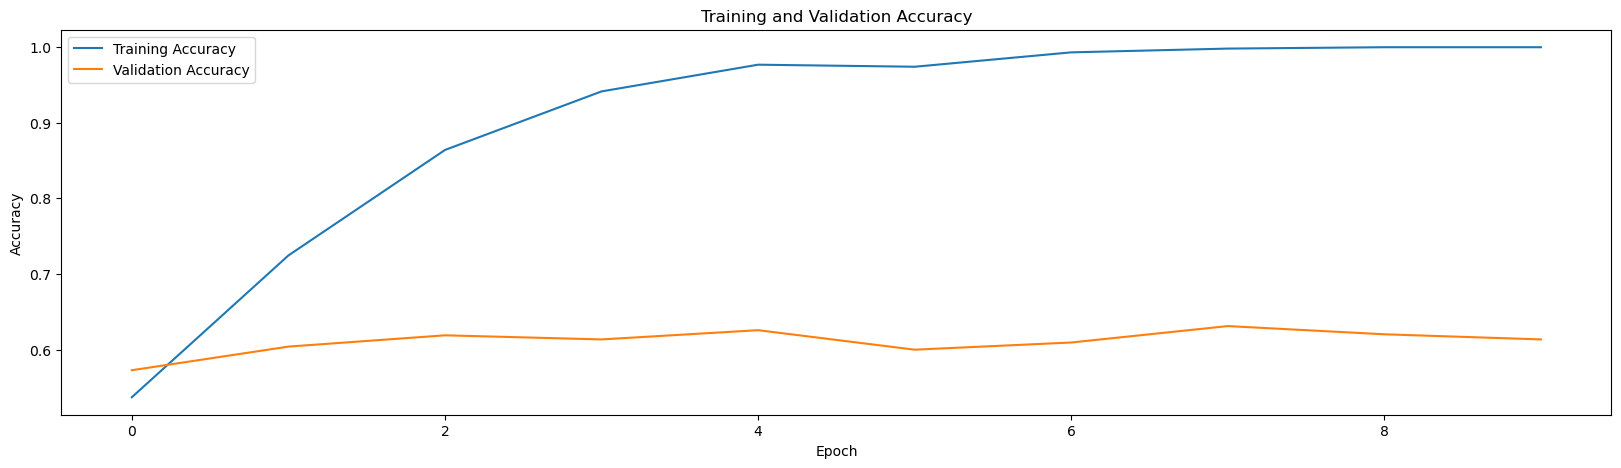

In [211]:
# Plotting training and validation accuracy over epochs
plt.figure(figsize=(20,5))
plt.plot(baseline_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

There is room for improvement for this model. Using more layers and dropout, it would be expected to get better accuracy on the validation and test set. It seems that the model overfits on the training set because of the high number of parameters.

## <a id='expandedCNN_id'></a>Expanded CNN model

The expanded has more layers and dropout to prevent overfitting on the training set.

In [41]:
expanded_model = tf.keras.Sequential([
    # Convolutional layer 1 with 32 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # Max pooling layer 1 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Convolutional layer 2 with 64 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    # Max pooling layer 2 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Convolutional layer 3 with 128 filters, each filter is a 3x3 kernel, activation function ReLU
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # Max pooling layer 3 with a 2x2 pool size
    tf.keras.layers.MaxPooling2D((2,2)),
    # Flatten layer to transform 3D tensor to a 1D tensor
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dropout(0.5),
    # Dense layer 1 with 512 neurons, activation function ReLU
    tf.keras.layers.Dense(512, activation='relu'),
    # Dense layer 2 with 1 neurons (output layer), activation function Sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with categorical crossentropy loss and Adam optimizer
expanded_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer="Adam", metrics=['accuracy'])

# Print model summary
expanded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 107, 107, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 51, 51, 64)       

In [42]:
tf.random.set_seed(42)

expanded_model_history = expanded_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
70/70 [==============================] - 9s 104ms/step - loss: 17.8808 - accuracy: 0.5741 - val_loss: 0.6193 - val_accuracy: 0.6328
Epoch 2/10
70/70 [==============================] - 5s 74ms/step - loss: 0.6261 - accuracy: 0.6478 - val_loss: 0.6097 - val_accuracy: 0.6951
Epoch 3/10
70/70 [==============================] - 5s 72ms/step - loss: 0.5434 - accuracy: 0.7116 - val_loss: 0.5725 - val_accuracy: 0.7087
Epoch 4/10
70/70 [==============================] - 5s 74ms/step - loss: 0.5576 - accuracy: 0.7043 - val_loss: 0.5633 - val_accuracy: 0.6938
Epoch 5/10
70/70 [==============================] - 5s 72ms/step - loss: 0.4774 - accuracy: 0.7514 - val_loss: 0.5451 - val_accuracy: 0.7507
Epoch 6/10
70/70 [==============================] - 5s 74ms/step - loss: 0.5397 - accuracy: 0.7342 - val_loss: 0.5387 - val_accuracy: 0.7331
Epoch 7/10
70/70 [==============================] - 5s 72ms/step - loss: 0.4537 - accuracy: 0.7762 - val_loss: 0.4990 - val_accuracy: 0.7534
Epoch 8/10


In [45]:
expanded_model.save('expanded_model.h5')

This model can then be tested on the test set to find the accuracy. The history can also be shown to analyze the training.

In [44]:
loss, accuracy = expanded_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', accuracy)

Test accuracy: 0.7750677466392517


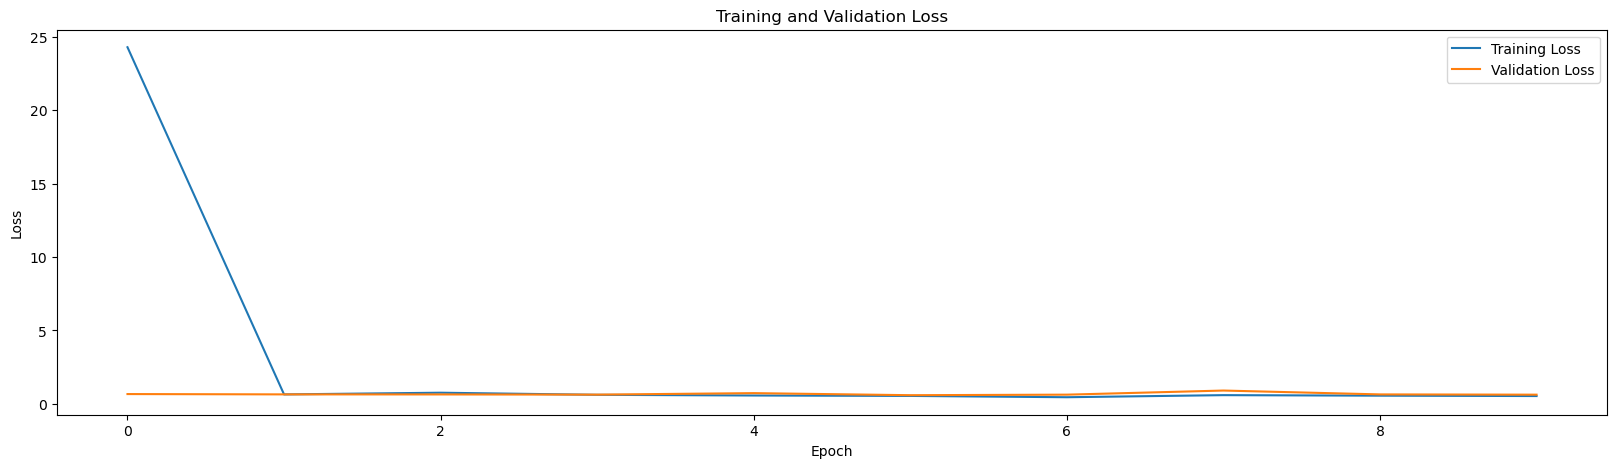

In [217]:
# Training and validation
plt.figure(figsize=(20,5))
plt.plot(expanded_model_history.history['loss'], label='Training Loss')
plt.plot(expanded_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

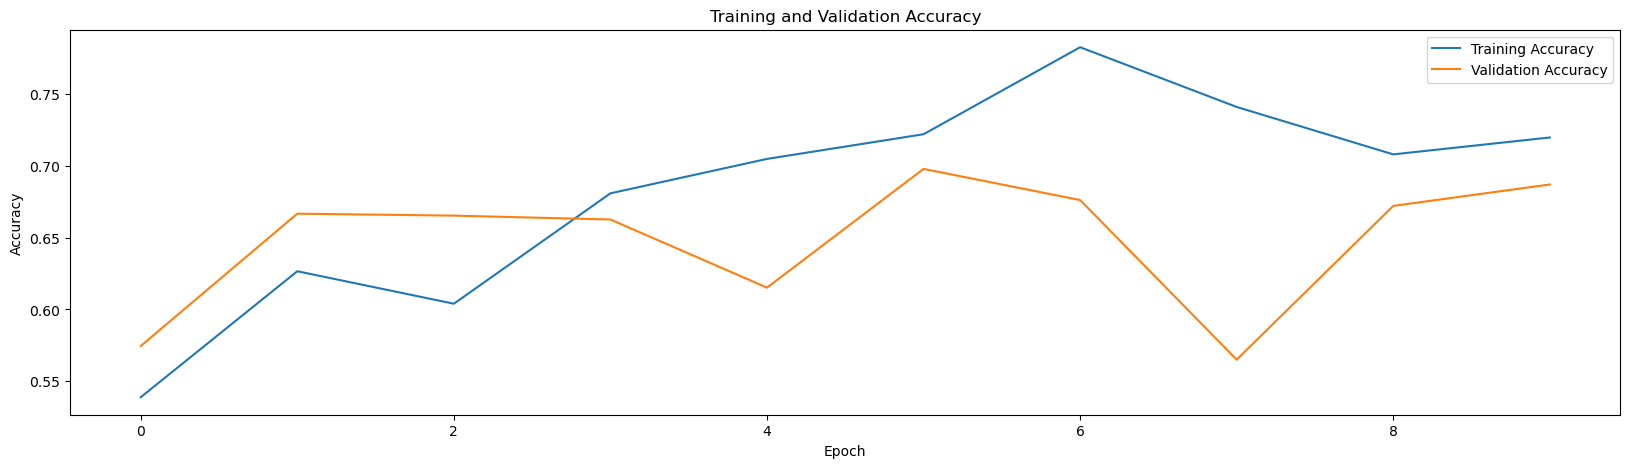

In [218]:
# Plotting training and validation accuracy over epochs
plt.figure(figsize=(20,5))
plt.plot(expanded_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(expanded_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

This model performs a lot better than the baseline model, but still overfits on the training set. Pre-trained models should therefore be included to get a better performance.

# <a id='retrainedModels_id'></a>Pre-trained models

Pre-trained models, also known as pre-trained models, are machine learning models that have been trained on large datasets to learn general patterns and features. Since these models have been trained already, it is easier for them to predict with better accuracy on other data. 

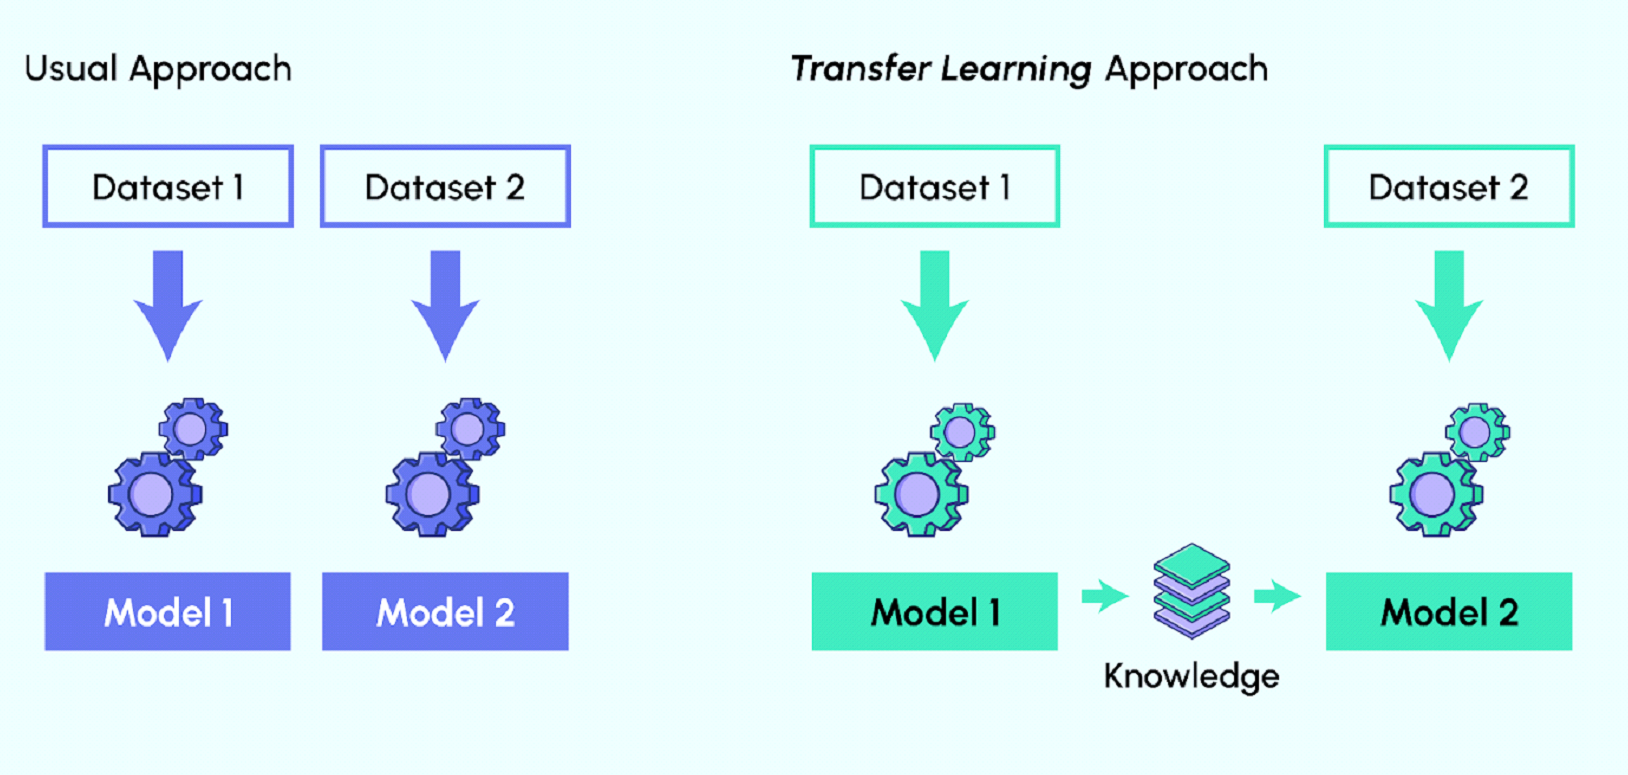

## <a id='resNet50_id'></a>CNN with pre-trained model: ResNet50

First model to be used is the pre-trained ResNet50. New layers are added to the end of the model to adjust for this case.

ResNet, short for "Residual Network," is a deep neural network architecture that was introduced in 2015 by Microsoft researchers. The architecture of ResNet consists of a series of residual blocks, each of which contains multiple convolutional layers. The resnet arhitecture we are using is trained on ImageNet. ImageNet is a large-scale image database that was created to support the development and evaluation of computer vision models, particularly for object recognition and image classification tasks.

In [226]:
# Create an instance of the ResNet50 model and specify the input shape to match the images
resnet_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# ResNet50 model

# Freeze the layers of the ResNet50 model to prevent their weights from being updated during training
for layer in resnet_model.layers:
    layer.trainable = False


# Add own layers on top of the ResNet50 model
resnet_model = tf.keras.Sequential([
    resnet_model,
    Conv2D(64, kernel_size=(3, 3), activation='relu', trainable=False),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and an optimizer of your choice
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [227]:
#Train and evaluate the model using on data:
resnet_history = resnet_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = resnet_model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/10
70/70 [==============================] - 19s 243ms/step - loss: 0.7298 - accuracy: 0.7184 - val_loss: 0.4836 - val_accuracy: 0.7818
Epoch 2/10
70/70 [==============================] - 13s 191ms/step - loss: 0.4143 - accuracy: 0.8119 - val_loss: 0.5405 - val_accuracy: 0.7683
Epoch 3/10
70/70 [==============================] - 13s 190ms/step - loss: 0.3750 - accuracy: 0.8332 - val_loss: 0.4359 - val_accuracy: 0.8171
Epoch 4/10
70/70 [==============================] - 13s 190ms/step - loss: 0.2943 - accuracy: 0.8770 - val_loss: 0.4522 - val_accuracy: 0.8076
Epoch 5/10
70/70 [==============================] - 14s 195ms/step - loss: 0.2581 - accuracy: 0.8834 - val_loss: 0.4406 - val_accuracy: 0.8333
Epoch 6/10
70/70 [==============================] - 13s 192ms/step - loss: 0.1970 - accuracy: 0.9222 - val_loss: 0.4760 - val_accuracy: 0.8184
Epoch 7/10
70/70 [==============================] - 13s 190ms/step - loss: 0.1707 - accuracy: 0.9354 - val_loss: 0.4773 - val_accuracy: 0.8035

In [231]:
# save the model
resnet_model.save('resnetModel.h5')

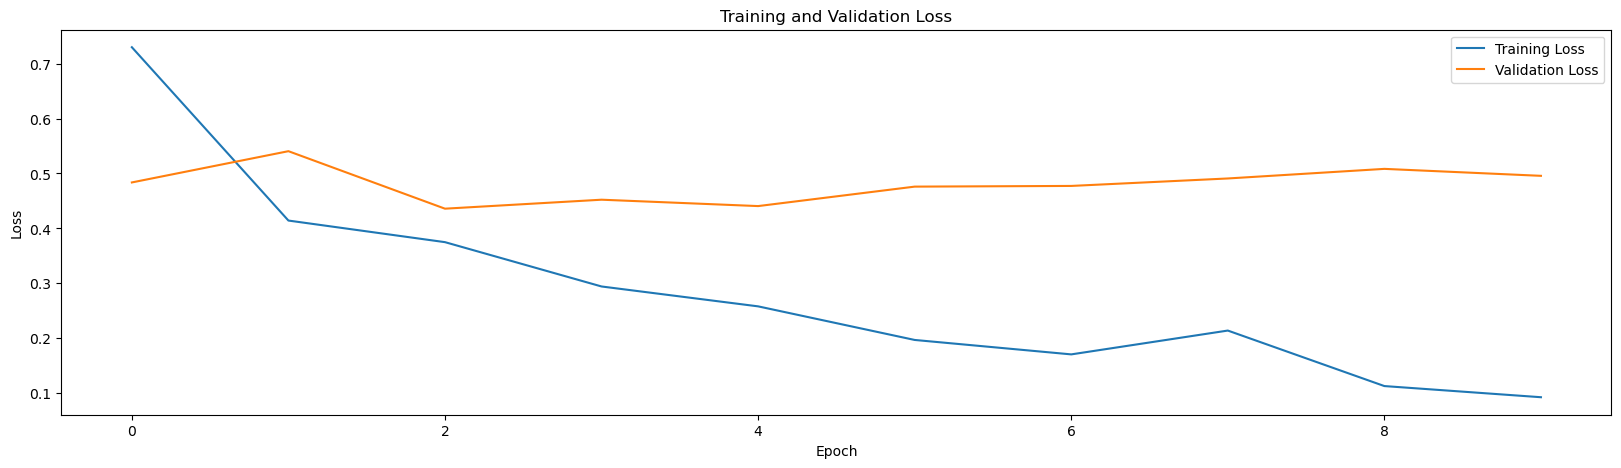

In [232]:
# training and validation loss
plt.figure(figsize=(20,5))
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

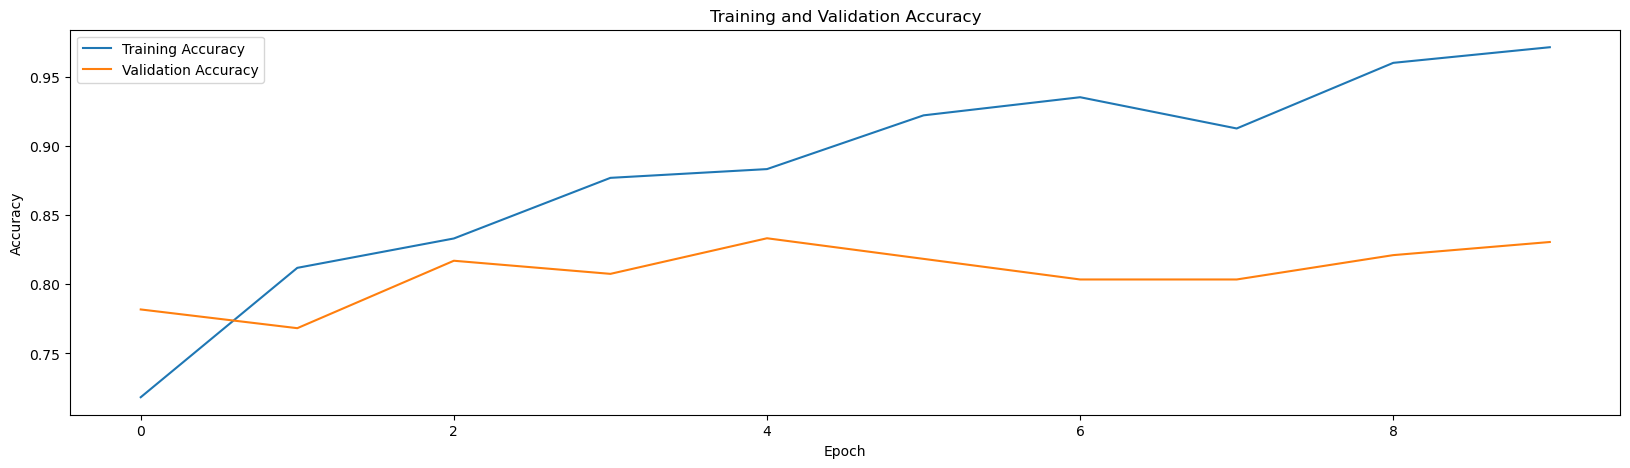

In [233]:
# Plotting training and validation accuracy over epochs
plt.figure(figsize=(20,5))
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## <a id='InceptionV3_id'></a>CNN with pretrained model: InceptionV3

Next model to test is InceptionV3 with the same layers afterwards as the ResNet model. InceptionV3 is a deep convolutional neural network architecture that was introduced by Google researchers in 2016. It is a successor to the original Inception architecture and is designed to achieve high accuracy on image classification tasks while minimizing the number of parameters and computational complexity.

In [234]:
# Create an instance of the InceptionV3 model and specify the input shape to match the images
inception_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers of the InceptionV3 model to prevent their weights from being updated during training
for layer in inception_model.layers:
    layer.trainable = False

# Add own layers on top of the InceptionV3 model
inception_model = tf.keras.Sequential([
    inception_model,
    Conv2D(64, kernel_size=(3, 3), activation='relu', trainable=False),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with binary crossentropy loss and an optimizer of your choice
inception_model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

In [235]:
#Train and evaluate the model using on data:
inception_history = inception_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = inception_model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/10
70/70 [==============================] - 17s 201ms/step - loss: 4.5279 - accuracy: 0.5976 - val_loss: 1.4259 - val_accuracy: 0.6653
Epoch 2/10
70/70 [==============================] - 10s 148ms/step - loss: 1.8665 - accuracy: 0.6505 - val_loss: 1.6261 - val_accuracy: 0.6314
Epoch 3/10
70/70 [==============================] - 10s 145ms/step - loss: 1.3366 - accuracy: 0.6741 - val_loss: 1.4032 - val_accuracy: 0.6518
Epoch 4/10
70/70 [==============================] - 10s 145ms/step - loss: 1.1607 - accuracy: 0.6731 - val_loss: 0.7817 - val_accuracy: 0.6911
Epoch 5/10
70/70 [==============================] - 10s 147ms/step - loss: 0.7531 - accuracy: 0.7102 - val_loss: 0.7536 - val_accuracy: 0.6721
Epoch 6/10
70/70 [==============================] - 10s 149ms/step - loss: 0.6199 - accuracy: 0.7373 - val_loss: 0.6207 - val_accuracy: 0.7060
Epoch 7/10
70/70 [==============================] - 10s 146ms/step - loss: 0.5367 - accuracy: 0.7414 - val_loss: 0.6306 - val_accuracy: 0.6843

In [240]:
# save the model
inception_model.save('inception_model.h5')

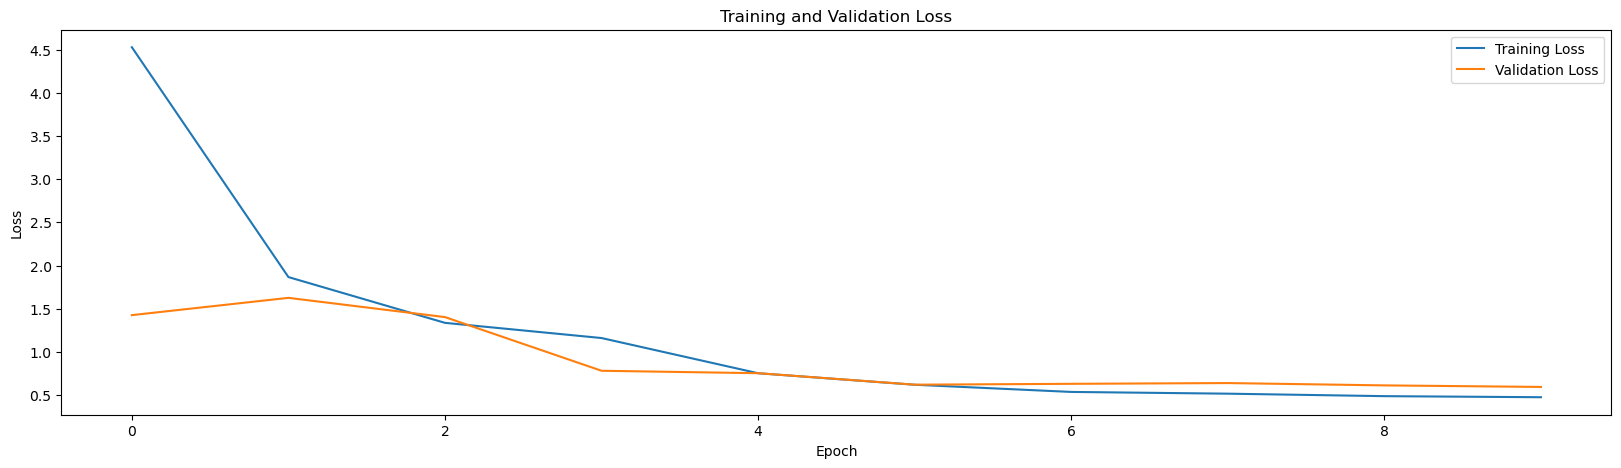

In [236]:
# training and validation loss
plt.figure(figsize=(20,5))
plt.plot(inception_history.history['loss'], label='Training Loss')
plt.plot(inception_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

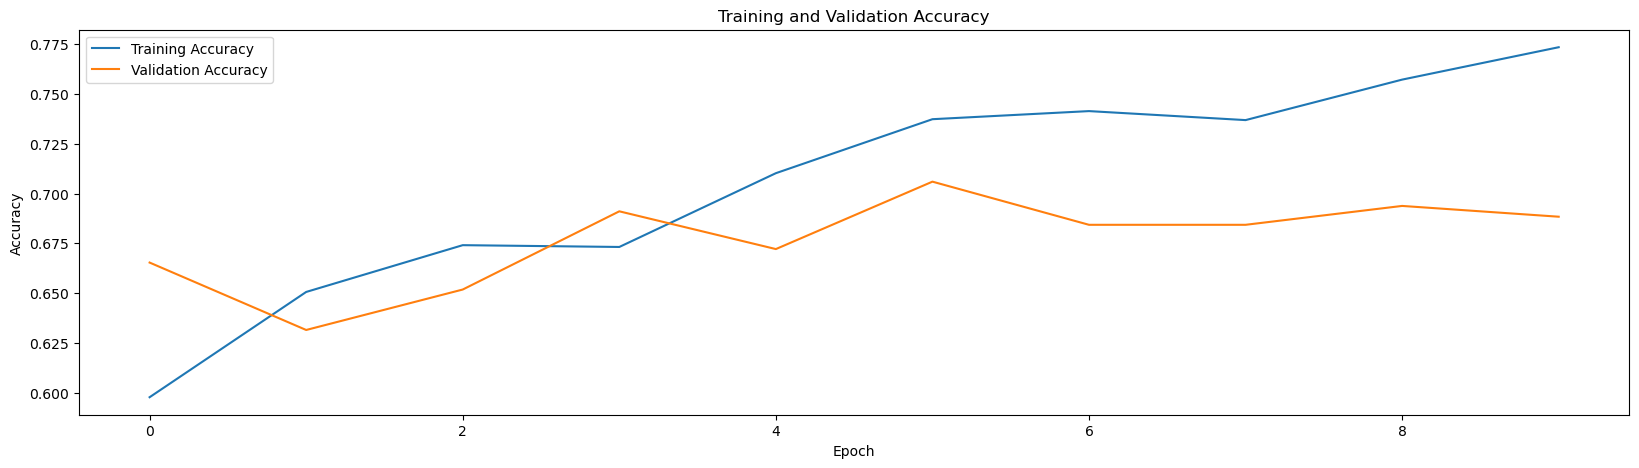

In [237]:
# Plotting training and validation accuracy over epochs
plt.figure(figsize=(20,5))
plt.plot(inception_history.history['accuracy'], label='Training Accuracy')
plt.plot(inception_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# <a id='bestmodel_id'></a>Which is the best model? 

Regarding metrics, the only one employed to evaluate these models was accuracy, and based on this criterion, the Resnet appears to be the top-performing model. However, for a more comprehensive evaluation, additional metrics should have been incorporated to determine the models' overall performance.

Furthermore, when it comes to overfitting, it can be concluded that the InceptionV3 outperformed the other models in this aspect.

# <a id='gradCam_id'></a>Grad-Cam

Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique for visualizing the regions of an input image that contribute most to a neural network's output predictions. We will see the Grad-Cam output of three of our models: expanded CNN, resnet and InceptionV3.

In [46]:
class GradCAM:
    """
    This class generate the Heatmap based on the last convolution layer in the model.
    """
    def __init__(self, model, class_idx, layer_name=None):
        self.model = model
        self.class_idx = class_idx
        self.layer_name = layer_name
        if self.layer_name is None:
            self.layer_name = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layer_name).output, self.model.output]
        )
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.class_idx]
        grads = tape.gradient(loss, convOutputs)
        guidedGrads = tf.cast(convOutputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

## GradCAM for the expanded_model

In [47]:
base_model = tf.keras.models.load_model('expanded_model.h5')
class_index = 0

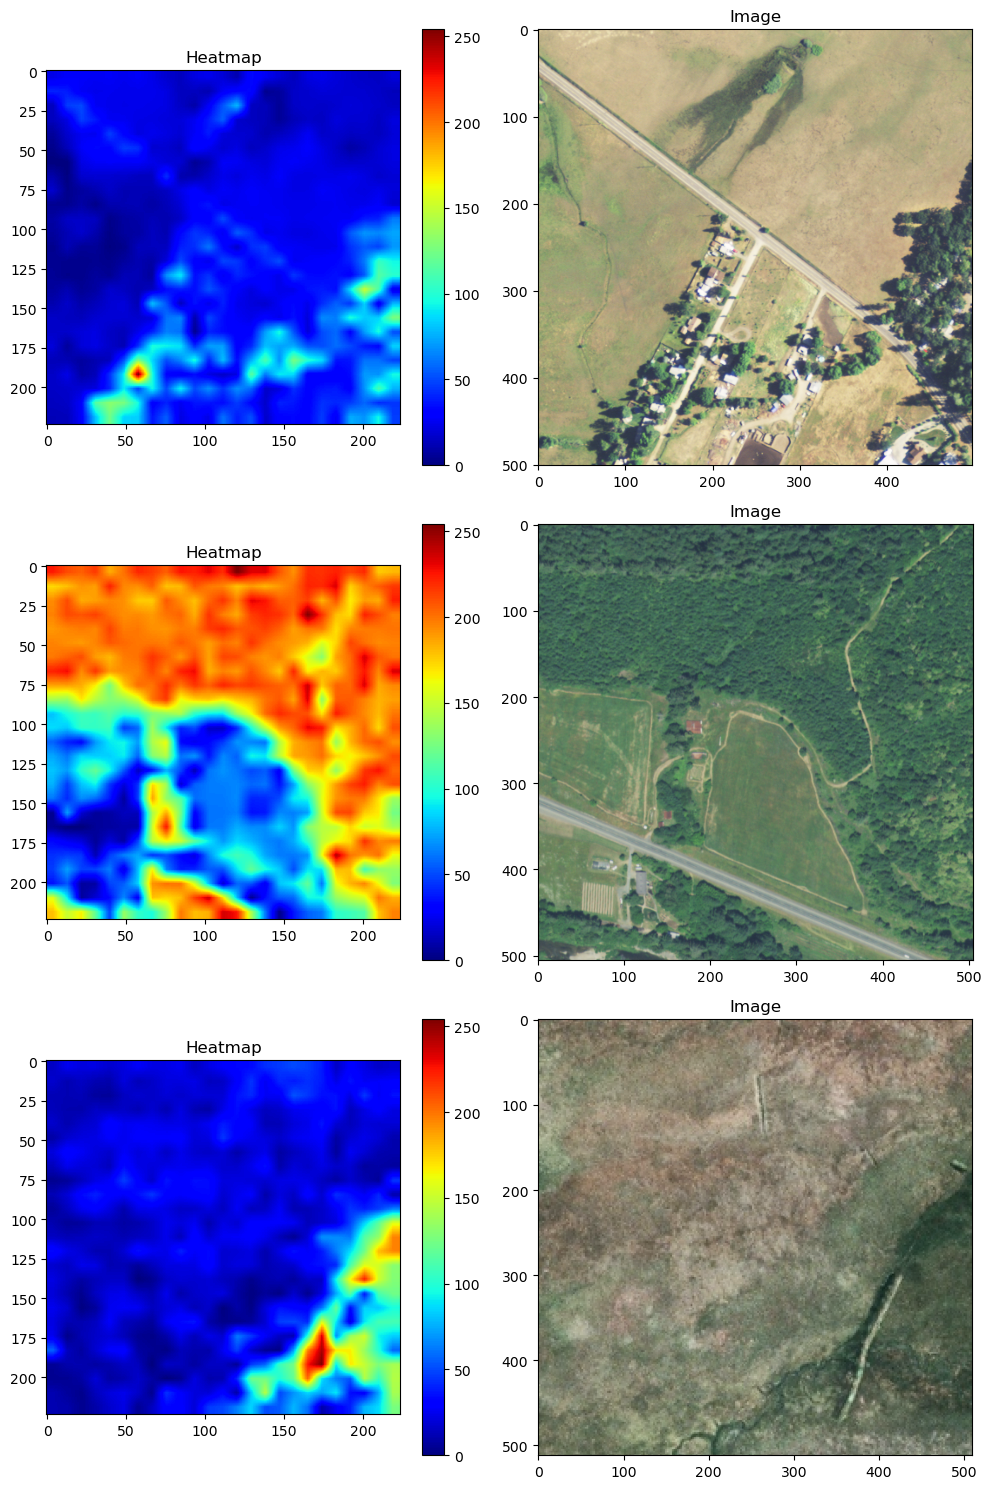

In [48]:
# Define the path to the image folder
img_folder = 'NAIP - 2-7 måneder før brand, 250 meter x 250 meter - NY 2'

# Get a list of all image file names in the folder
img_files = os.listdir(img_folder)

# Select 3 random images from the folder
random.seed(42) # set a seed for reproducibility
img_files = random.sample(img_files, 3)

# Set up the subplots for displaying the images and heatmaps side-by-side
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# Loop over the selected images and display them with their heatmaps
for i, img_file in enumerate(img_files):
    # Load and preprocess the image
    img_path = os.path.join(img_folder, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Compute the GradCAM heatmap for the image
    cam = GradCAM(model=base_model, class_idx=class_index)
    heatmap = cam.compute_heatmap(img)

    # Display the heatmap and image side-by-side in the subplot
    im1 = axs[i][0].imshow(heatmap, cmap='jet')
    axs[i][0].set_title('Heatmap')
    plt.colorbar(im1, ax=axs[i][0])
    im2 = axs[i][1].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[i][1].set_title('Image')

# Show the plot
plt.tight_layout()
plt.show()


When applying Grad-CAM to our model, it is interesting to note that the model often weights roads, houses, or other places that humans normally use more heavily. Also, as aspected the areas where there is a lot of trees together are more susceptible to wild-fires. This is significant because we know that most wildfires start from human activity. <a href="https://catalog.extension.oregonstate.edu/em9228/html">[1]</a>

## GradCAM for the Resnet model 

In [10]:
resnet_model = tf.keras.models.load_model('resnetModel.h5')
class_index = 0

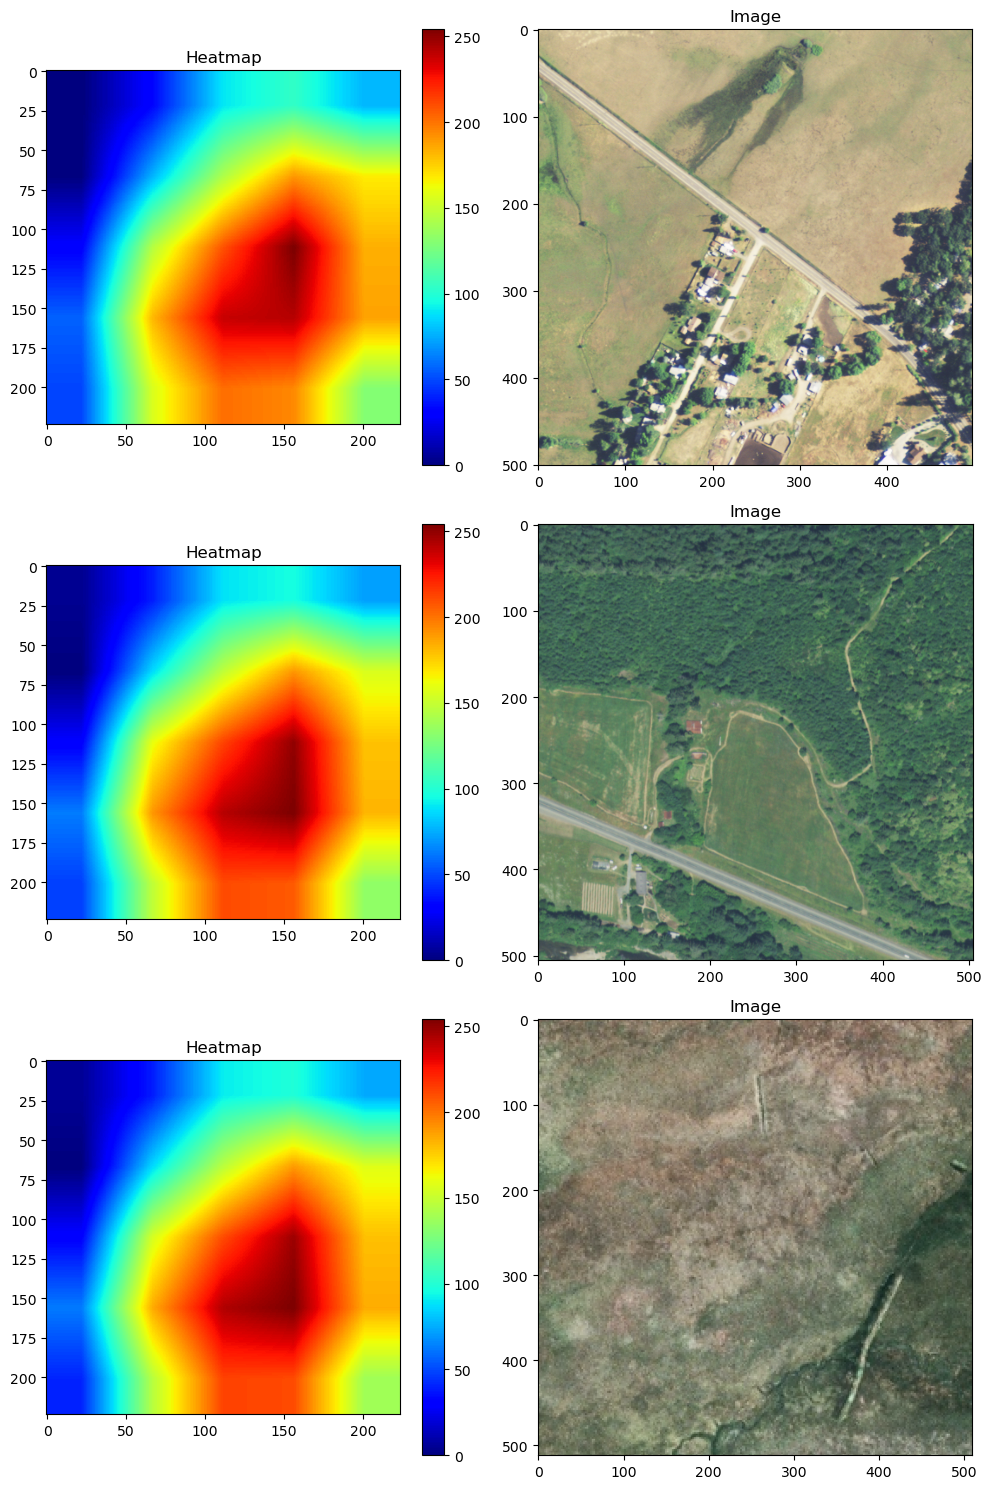

In [11]:
# Define the path to the image folder
img_folder = 'NAIP - 2-7 måneder før brand, 250 meter x 250 meter - NY 2'

# Get a list of all image file names in the folder
img_files = os.listdir(img_folder)

# Select 3 random images from the folder
random.seed(42)  # set a seed for reproducibility
img_files = random.sample(img_files, 3)

# Set up the subplots for displaying the images and heatmaps side-by-side
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# Loop over the selected images and display them with their heatmaps
for i, img_file in enumerate(img_files):
    # Load and preprocess the image
    img_path = os.path.join(img_folder, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Compute the GradCAM heatmap for the image
    cam = GradCAM(model=resnet_model, class_idx=class_index)
    heatmap = cam.compute_heatmap(img)

    # Display the heatmap and image side-by-side in the subplot
    im1 = axs[i][0].imshow(heatmap, cmap='jet')
    axs[i][0].set_title('Heatmap')
    plt.colorbar(im1, ax=axs[i][0])
    im2 = axs[i][1].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[i][1].set_title('Image')

# Show the plot
plt.tight_layout()
plt.show()


Identifying the key factors considered by this model when predicting fires is somewhat challenging, and this ambiguity may be attributed to either an error in the code or the model's design

## GradCAM for the Inception model 

In [17]:
inception_model = tf.keras.models.load_model('inception_model.h5')
class_index = 0

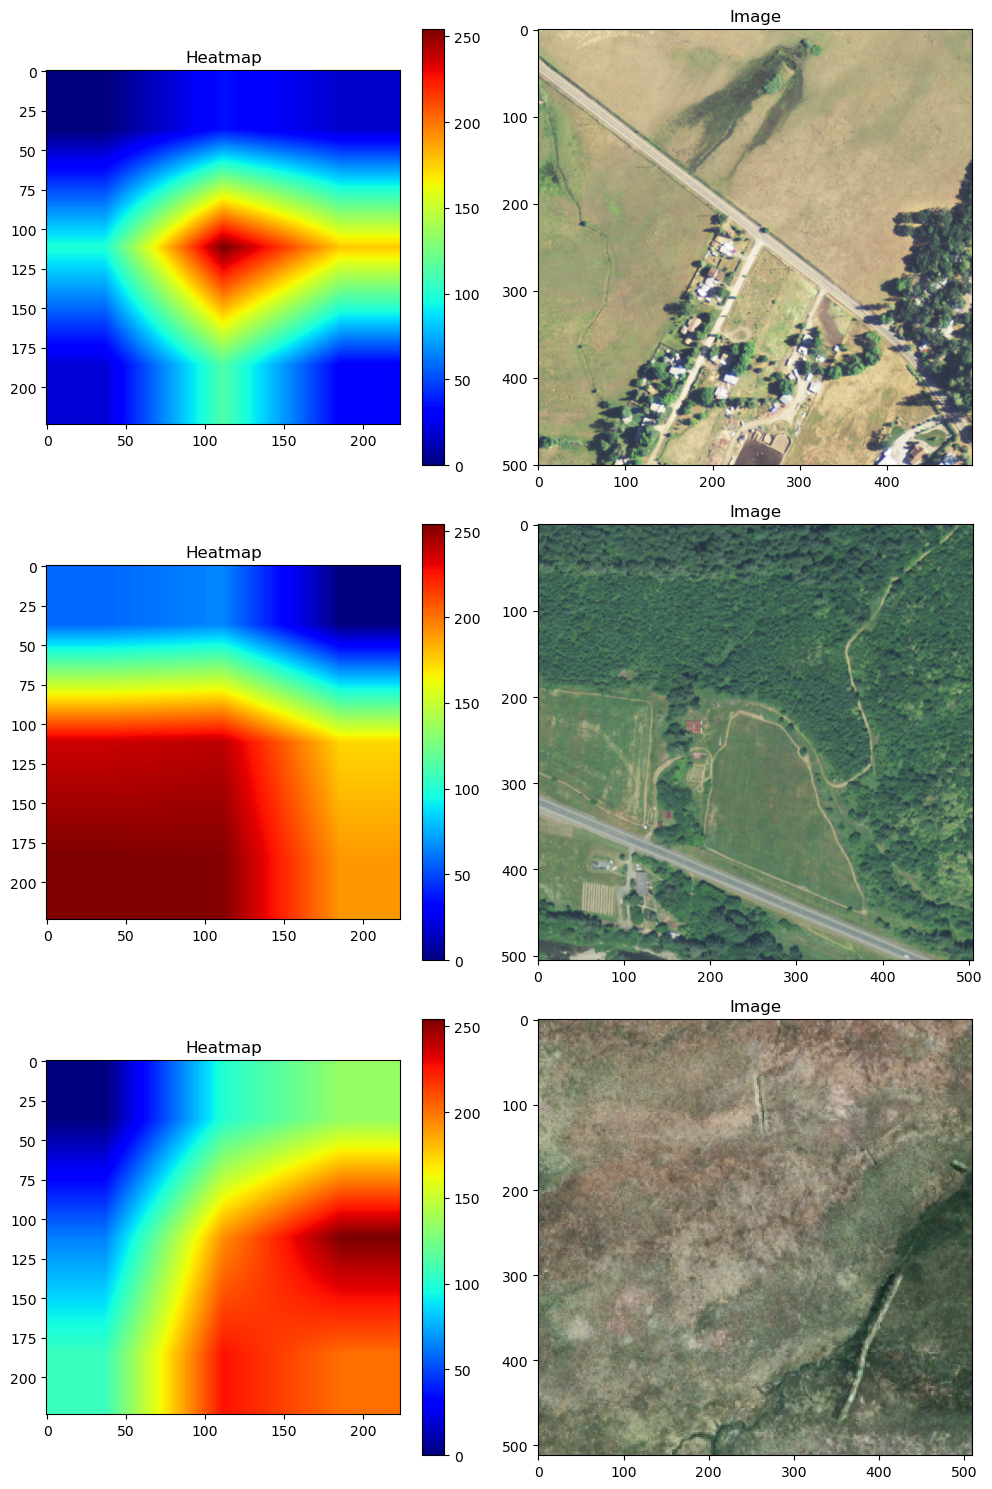

In [18]:
# Define the path to the image folder
img_folder = 'NAIP - 2-7 måneder før brand, 250 meter x 250 meter - NY 2'

# Get a list of all image file names in the folder
img_files = os.listdir(img_folder)

# Select 3 random images from the folder
random.seed(42)  # set a seed for reproducibility
img_files = random.sample(img_files, 3)

# Set up the subplots for displaying the images and heatmaps side-by-side
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# Loop over the selected images and display them with their heatmaps
for i, img_file in enumerate(img_files):
    # Load and preprocess the image
    img_path = os.path.join(img_folder, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Compute the GradCAM heatmap for the image
    cam = GradCAM(model=inception_model, class_idx=class_index)
    heatmap = cam.compute_heatmap(img)

    # Display the heatmap and image side-by-side in the subplot
    im1 = axs[i][0].imshow(heatmap, cmap='jet')
    axs[i][0].set_title('Heatmap')
    plt.colorbar(im1, ax=axs[i][0])
    im2 = axs[i][1].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[i][1].set_title('Image')

# Show the plot
plt.tight_layout()
plt.show()


While it may be challenging to draw firm conclusions from the provided heatmap, one could argue that the model places some emphasis on human activity as a predictor for fires, based on the second heatmap.